# Evaluate Geocoder Performance
* Score
* Centroid Distance

In [42]:
import os
import sys
import re
import csv
from math import sin, cos, sqrt, atan2, radians

import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import matplotlib.patches

# Load CLAD OMOP Simulated Output
* PostGIS
* DeGauss
* Nominatim

In [2]:
os.chdir('..')
abs_path = os.getcwd()

output_path = os.path.join(abs_path, 'output')
clad_omop_output_file = "clad_omop_simulated_output_4.xlsx"
clad_omop_output_path = os.path.join(output_path, clad_omop_output_file)

omop_simulated_file = "OMOP_sample_simulated_residential.csv"
omop_simulated_path = os.path.join(output_path, omop_simulated_file)

logan_clean_file = "geocode_comparison_clean.csv"
logan_clean_path = os.path.join(output_path, logan_clean_file)

In [3]:
address_df = pd.read_excel(clad_omop_output_path, sheet_name='address_list', engine="openpyxl")
degauss_df = pd.read_excel(clad_omop_output_path, sheet_name='degauss_responses', engine="openpyxl")
postgis_df = pd.read_excel(clad_omop_output_path, sheet_name='postgis_responses', engine="openpyxl")
nominatim_df = pd.read_excel(clad_omop_output_path, sheet_name='nominatim_responses', engine="openpyxl")

print(f"There are {degauss_df.shape[0]} outputs from DeGauss for {address_df.shape[0]} addresses")
print(f"There are {postgis_df.shape[0]} outputs from PostGIS for {address_df.shape[0]} addresses")
print(f"There are {nominatim_df.shape[0]} outputs from Nominatim for {address_df.shape[0]} addresses")

source_address_df = pd.read_csv(omop_simulated_path)
logan_df = pd.read_csv(logan_clean_path)

There are 534 outputs from DeGauss for 523 addresses
There are 500 outputs from PostGIS for 523 addresses
There are 648 outputs from Nominatim for 523 addresses


In [5]:
def format_address(x):
    # address = str(x.address_1) + str(x.address_2) + str(x.city) + str(x.state_abbr) + str(x.zip).rjust(5, '0')
    address = str(x.address_1).title()
    address = address.replace(" ", "+")
    address = address + "%2c+" + str(x.city) + "%2c+" + str(x.state_abbr) + "+" + str(x.zip).rjust(5, '0')

    return address

In [6]:
source_address_df["address"] = source_address_df.apply(lambda x: format_address(x), axis=1)
# source_address_df

In [7]:
source_address_df.columns

Index(['Location_id', 'address_1', 'address_2', 'city', 'state', 'zip',
       'county', 'location_source_value', 'latitude', 'longitude',
       'address_type', 'state_abbr', 'flag', 'user_id', 'start_date',
       'end_duration', 'end_date', 'address'],
      dtype='object')

In [4]:
logan_df

,id,state_abbr,address_type,location_source_value,lat_input,long_input,geocoder,rating_postgis,lat_gc,long_gc,result_postgis,geometry,score_degauss,precision_degauss,result_degauss,type_gc,result_nominatim,failure,geometry_true,gc_diff_m
0,0,CA,Street Address,"41100 PINEBENCH ROAD, YUCAIPA, CA 92399",34.033329,-116.906094,degauss,NaN,34.035802,-116.909906,NaN,"c(-116.909906, 34.035802)",0.977,range,1.0,NaN,NaN,False,"c(-116.906093794528, 34.0333292555953)",446.096830
1,0,CA,Street Address,"41100 PINEBENCH ROAD, YUCAIPA, CA 92399",34.033329,-116.906094,nominatim,NaN,NaN,NaN,NaN,"c(NA, NA)",NaN,NaN,NaN,NaN,NaN,True,"c(-116.906093794528, 34.0333292555953)",NaN
2,0,CA,Street Address,"41100 PINEBENCH ROAD, YUCAIPA, CA 92399",34.033329,-116.906094,postgis,18.0,34.035780,-116.909930,1.0,"c(-116.90993, 34.03578)",NaN,NaN,NaN,NaN,NaN,False,"c(-116.906093794528, 34.0333292555953)",446.342691
3,1,CT,Street Address,"2 VAIL RD, BETHEL, CT 6801",41.417546,-73.393808,degauss,NaN,41.418305,-73.393318,NaN,"c(-73.393318, 41.418305)",0.878,range,1.0,NaN,NaN,False,"c(-73.3938079996471, 41.4175460000301)",93.767374
4,1,CT,Street Address,"2 VAIL RD, BETHEL, CT 6801",41.417546,-73.393808,nominatim,NaN,41.418118,-73.394610,NaN,"c(-73.3946095, 41.4181184)",NaN,NaN,NaN,house,1.0,False,"c(-73.3938079996471, 41.4175460000301)",92.292066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1824,521,MS,Street Address,"2861 SOUTH HARPER ROAD, CORINTH, MS 38834",34.909434,-88.556540,nominatim,NaN,34.930795,-88.495255,NaN,"c(-88.4952546, 34.9307949)",NaN,NaN,NaN,tertiary,1.0,False,"c(-88.5565396925065, 34.9094344455495)",6071.505880
1825,521,MS,Street Address,"2861 SOUTH HARPER ROAD, CORINTH, MS 38834",34.909434,-88.556540,postgis,0.0,34.910350,-88.556630,1.0,"c(-88.55663, 34.91035)",NaN,NaN,NaN,NaN,NaN,False,"c(-88.5565396925065, 34.9094344455495)",102.137672
1826,522,KY,Street Address,"1022 WEST MAIN STREET, BOWLING GREEN, KY 42101",37.007103,-86.454949,degauss,NaN,37.006634,-86.455272,NaN,"c(-86.455272, 37.006634)",0.912,range,1.0,NaN,NaN,False,"c(-86.4549489188064, 37.0071027417496)",59.495431
1827,522,KY,Street Address,"1022 WEST MAIN STREET, BOWLING GREEN, KY 42101",37.007103,-86.454949,nominatim,NaN,NaN,NaN,NaN,"c(NA, NA)",NaN,NaN,NaN,NaN,NaN,True,"c(-86.4549489188064, 37.0071027417496)",NaN


## Merge on Source Address

In [8]:
degauss_df_source = degauss_df.merge(source_address_df, on="address", how="left")
postgis_df_source = postgis_df.merge(source_address_df, on="address", how="left")
nominatim_df_source = nominatim_df.merge(source_address_df, on="address", how="left")

degauss_df_source = degauss_df_source.rename(columns={"lon": "geo_long"})

# Evaluate

In [70]:
nlp = spacy.load("en_core_web_lg")

def text_similarity(source_address, parsed_address):
    """
    Calculate cosine similarity between two strings

    Parameters
    ----------
    source_address (str): original address string input to a geocoder
    parsed_addres (str): returned address string from a geocoder

    Returns
    -------
    score (float)
    """
    # capitalize first letter only of each word
    doc1 = nlp(source_address.title())
    doc2 = nlp(parsed_address.title())

    # print(f"The similarity between \033[1m{source_address} \033[0mand \033[1m{parsed_address} is \033[0m{doc1.similarity(doc2)}.")
    return doc1.similarity(doc2)

In [51]:
def euclidean_distance(source_centroid, predicted_centroid):
    """
    Calculate Euclidean distance between two points

    Parameters
    ----------
    source_centroid (NumPy array): (source_lat, source_lon)
    predicted_centroid (NumPy array):(predicted_lat, predicted_lon)

    Returns
    -------
    dist (float)
    """
    dist = np.sqrt(np.sum(np.square(source_centroid - predicted_centroid)))

    return dist

In [9]:
def centroid_distance(source_lat, source_lon, predicted_lat, predicted_lon):
    """
    Calculates distance between two geospatial points

    Returns
    -------
    dist (float): in meters
    """
    # Approximate radius of earth in km
    R = 6373.0

    lat1 = radians(source_lat)
    lon1 = radians(source_lon)
    lat2 = radians(predicted_lat)
    lon2 = radians(predicted_lon)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    # c = 2 * atan2(sqrt(a), sqrt(1 - a))

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2) **2
    c = 2 * np.arctan2(a**0.5, (1-a)**0.5)

    dist = R * c

    return dist*1000

In [10]:
print(f"DeGauss columns: {degauss_df_source.columns}")
print(f"PostGIS columns: {postgis_df_source.columns}")
print(f"Nominatim columns: {nominatim_df_source.columns}")

DeGauss columns: Index(['street', 'geo_zip', 'geo_city', 'geo_state', 'geo_lat', 'geo_long',
       'geo_fips_county', 'geo_score', 'prenum', 'number', 'geo_precision',
       'id', 'api_version', 'address', 'degauss_json', 'postgis_json',
       'nominatim_json', 'Location_id', 'address_1', 'address_2', 'city',
       'state', 'zip', 'county', 'location_source_value', 'latitude',
       'longitude', 'address_type', 'state_abbr', 'flag', 'user_id',
       'start_date', 'end_duration', 'end_date'],
      dtype='object')
PostGIS columns: Index(['geo_building', 'geo_city', 'geo_lat', 'geo_long', 'rating',
       'geo_state', 'geo_street', 'geo_streetType', 'geo_zip', 'id',
       'api_version', 'address', 'degauss_json', 'postgis_json',
       'nominatim_json', 'Location_id', 'address_1', 'address_2', 'city',
       'state', 'zip', 'county', 'location_source_value', 'latitude',
       'longitude', 'address_type', 'state_abbr', 'flag', 'user_id',
       'start_date', 'end_duration', 'end_d

In [11]:
def get_distance(x):
    # source_centroid = np.array([x.longitude, x.latitude])
    # predicted_centroid = np.array([x.geo_long, x.geo_lat])

    dist = centroid_distance(x.latitude, x.longitude, x.geo_lat, x.geo_long)

    return dist

In [12]:
def get_nominatim_address(x):
    nominatim_address_split = x.geo_display_name.split(",")
    nominatim_address = nominatim_address_split[0] + "+" + nominatim_address_split[1] + "%2c+" + nominatim_address_split[2] + "%2c+" + nominatim_address_split[4] + "+" + str(x.zip).rjust(5, '0')
    nomiatim_address = nominatim_address.replace(" ", "")
    # score = text_similarity(x.address, nominatim_address)

    return nominatim_address

In [13]:
def get_simliarity_nominatim(x):
    nominatim_address_split = x.geo_display_name.split(",")
    nominatim_address = nominatim_address_split[0] + "+" + nominatim_address_split[1] + "%2c+" + nominatim_address_split[2] + "%2c+" + nominatim_address_split[4] + "+" + str(x.zip).rjust(5, '0')
    nomiatim_address = nominatim_address.replace(" ", "")
    score = text_similarity(x.address, nominatim_address)

    return score

# Calculate Centroid Distance

In [14]:
# calculate Euclidean distance for each lat/lon against ground truth lat/lon
degauss_df_source["centroid_dist"] = degauss_df_source.apply(lambda x: get_distance(x), axis=1)
postgis_df_source["centroid_dist"] = degauss_df_source.apply(lambda x: get_distance(x), axis=1)
nominatim_df_source["centroid_dist"] = degauss_df_source.apply(lambda x: get_distance(x), axis=1)

In [15]:
degauss_df_source

,street,geo_zip,geo_city,geo_state,geo_lat,geo_long,geo_fips_county,geo_score,prenum,number,...,latitude,longitude,address_type,state_abbr,flag,user_id,start_date,end_duration,end_date,centroid_dist
0,Pine Bench Rd,92399,Yucaipa,CA,34.035802,-116.909906,6071.0,0.977,NaN,41100.0,...,34.033329,-116.906094,Street Address,CA,SUCCESSFUL ADDRESS,16.0,2011-08-27,423 days 00:00:00,2012-10-23,446.236169
1,Vail Rd,6801,Bethel,CT,41.418305,-73.393318,9001.0,0.878,NaN,2.0,...,41.417546,-73.393808,Street Address,CT,SUCCESSFUL ADDRESS,16.0,2017-03-21,851 days 00:00:00,2019-07-20,93.796662
2,NaN,96913,Barrigada,GU,13.444257,144.786297,66010.0,0.598,NaN,NaN,...,13.486157,144.843145,Street Address,GU,SUCCESSFUL ADDRESS,16.0,2019-11-16,606 days 00:00:00,2021-07-14,7715.949444
3,Medical Dr,32308,Tallahassee,FL,30.458759,-84.259384,12073.0,1.000,NaN,1541.0,...,30.459053,-84.259273,Street Address,FL,SUCCESSFUL ADDRESS,17.0,2008-04-17,785 days 00:00:00,2010-06-11,34.436355
4,E 32nd Ave,99504,Anchorage,AK,61.191672,-149.736182,2020.0,0.941,NaN,7801.0,...,61.192277,-149.735520,Street Address,AK,SUCCESSFUL ADDRESS,17.0,2020-11-27,569 days 00:00:00,2022-06-19,76.121145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,Franklin St S,56334,Glenwood,MN,45.650230,-95.390028,27121.0,0.910,NaN,2.0,...,45.650139,-95.390079,Street Address,MN,SUCCESSFUL ADDRESS,198.0,2021-02-20,855 days 00:00:00,2023-06-25,10.870966
530,Franklin St N,56334,Glenwood,MN,45.650230,-95.390028,27121.0,0.910,NaN,2.0,...,45.650139,-95.390079,Street Address,MN,SUCCESSFUL ADDRESS,198.0,2021-02-20,855 days 00:00:00,2023-06-25,10.870966
531,Lowell St,3104,Manchester,NH,42.993673,-71.458179,33011.0,0.878,NaN,145.0,...,42.993533,-71.457871,Street Address,NH,SUCCESSFUL ADDRESS,199.0,2000-01-20,427 days 00:00:00,2001-03-22,29.502385
532,S Harper Rd,38834,Corinth,MS,34.910361,-88.556521,28003.0,1.000,NaN,2861.0,...,34.909434,-88.556540,Street Address,MS,SUCCESSFUL ADDRESS,199.0,2003-09-13,544 days 00:00:00,2005-03-10,103.074600


In [16]:
nominatim_df_source["full_address"] = nominatim_df_source.apply(lambda x: get_nominatim_address(x), axis=1)
nominatim_df_source

,geo_lat,geo_long,geo_address,geo_display_name,geo_class,geo_type,id,address,degauss_json,postgis_json,...,longitude,address_type,state_abbr,flag,user_id,start_date,end_duration,end_date,centroid_dist,full_address
0,41.418118,-73.394610,"{'house_number': '2', 'road': 'Vail Road', 'to...","2, Vail Road, Bethel, Western Connecticut Plan...",place,house,1,2+Vail+Rd%2c+Bethel%2c+CT+06801,"[{'street': 'Vail Rd', 'zip': '06801', 'city':...","{'building': None, 'city': 'Bethel', 'lat': 41...",...,-73.393808,Street Address,CT,SUCCESSFUL ADDRESS,16.0,2017-03-21,851 days 00:00:00,2019-07-20,446.236169,2+ Vail Road%2c+ Bethel%2c+ Connecticut+06801
1,30.458798,-84.259518,"{'road': 'Medical Drive', 'city': 'Tallahassee...","Medical Drive, Tallahassee, Leon County, Flori...",highway,unclassified,3,1541+Medical+Drive%2c+Tallahassee%2c+FL+32308,"[{'street': 'Medical Dr', 'zip': '32308', 'cit...","{'building': 1541, 'city': 'Tallahassee', 'lat...",...,-84.259273,Street Address,FL,SUCCESSFUL ADDRESS,17.0,2008-04-17,785 days 00:00:00,2010-06-11,93.796662,Medical Drive+ Tallahassee%2c+ Leon County%2c+...
2,61.192286,-149.735362,{'amenity': 'Wayland Baptist University-Anchor...,"Wayland Baptist University-Anchorage, 7801, Ea...",amenity,university,4,7801+E+32Nd+Ave%2c+Anchorage%2c+AK+99504,"[{'street': 'E 32nd Ave', 'zip': '99504', 'cit...","{'building': 7801, 'city': 'Anchorage', 'lat':...",...,-149.735520,Street Address,AK,SUCCESSFUL ADDRESS,17.0,2020-11-27,569 days 00:00:00,2022-06-19,7715.949444,Wayland Baptist University-Anchorage+ 7801%2c+...
3,61.192474,-149.734916,"{'place': 'STrEaM Academy', 'house_number': '7...","STrEaM Academy, 7801, East 32nd Avenue, Anchor...",place,house,4,7801+E+32Nd+Ave%2c+Anchorage%2c+AK+99504,"[{'street': 'E 32nd Ave', 'zip': '99504', 'cit...","{'building': 7801, 'city': 'Anchorage', 'lat':...",...,-149.735520,Street Address,AK,SUCCESSFUL ADDRESS,17.0,2020-11-27,569 days 00:00:00,2022-06-19,34.436355,STrEaM Academy+ 7801%2c+ East 32nd Avenue%2c+ ...
4,61.192335,-149.735055,"{'house_number': '7801', 'road': 'East 32nd Av...","7801, East 32nd Avenue, Anchorage, 99504, Unit...",amenity,bicycle_parking,4,7801+E+32Nd+Ave%2c+Anchorage%2c+AK+99504,"[{'street': 'E 32nd Ave', 'zip': '99504', 'cit...","{'building': 7801, 'city': 'Anchorage', 'lat':...",...,-149.735520,Street Address,AK,SUCCESSFUL ADDRESS,17.0,2020-11-27,569 days 00:00:00,2022-06-19,76.121145,7801+ East 32nd Avenue%2c+ Anchorage%2c+ Unite...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,33.587898,-86.284150,"{'road': '1st Avenue North', 'neighbourhood': ...","1st Avenue North, Avondale Village, Harrisburg...",highway,residential,518,1805+1St+Ave+N%2c+Pell+City%2c+AL+35120,"[{'street': 'Old Forest Dr', 'zip': '35120', '...","{'building': 805, 'city': 'Oneonta', 'lat': 33...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1st Avenue North+ Avondale Village%2c+ Harrisb...
644,33.592962,-86.269345,"{'road': '1st Avenue North', 'neighbourhood': ...","1st Avenue North, Crestview Gardens, Pell City...",highway,residential,518,1805+1St+Ave+N%2c+Pell+City%2c+AL+35120,"[{'street': 'Old Forest Dr', 'zip': '35120', '...","{'building': 805, 'city': 'Oneonta', 'lat': 33...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1st Avenue North+ Crestview Gardens%2c+ Pell C...
645,45.647689,-95.390030,"{'road': 'South Franklin Street', 'village': '...","South Franklin Street, Glenwood, Pope County, ...",highway,secondary,519,2+South+Franklin+Street%2c+Glenwood%2c+MN+56334,"[{'street': 'Franklin St S', 'zip': '56334', '...","{'building': 2, 'city': 'Glenwood', 'lat': 45....",...,-95.390079,Street Address,MN,SUCCESSFUL ADDRESS,198.0,2021-02-20,855 days 00:00:00,2023-06-25,NaN,South Franklin Street+ Glenwood%2c+ Pope Count...
646,42.993336,-71.457946,{'building': 'St. Joseph Cathedral Parish Rect...,"St. Joseph Cathedral Parish Rectory, 145, Lowe...",building,residential,520,145+Lowell+St%2c+Manchester%2c+NH+03104,"[{'street': 'Lowell St', 'zip': '0

In [105]:
nominatim_df_source["score"] = nominatim_df_source.apply(lambda x: get_simliarity_nominatim(x), axis=1)
nominatim_df_source

C:\Users\bchan\AppData\Local\Temp\ipykernel_27264\52803196.py:21: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return doc1.similarity(doc2)


,geo_lat,geo_long,geo_address,geo_display_name,geo_class,geo_type,id,address,degauss_json,postgis_json,...,state_abbr,flag,user_id,start_date,end_duration,end_date,format_address,centroid_dist,score,full_address
0,41.418118,-73.394610,"{'house_number': '2', 'road': 'Vail Road', 'to...","2, Vail Road, Bethel, Western Connecticut Plan...",place,house,1,2+Vail+Rd%2c+Bethel%2c+CT+06801,"[{'street': 'Vail Rd', 'zip': '06801', 'city':...","{'building': None, 'city': 'Bethel', 'lat': 41...",...,CT,SUCCESSFUL ADDRESS,16.0,2017-03-21,851 days 00:00:00,2019-07-20,2+Vail+Rd,0.004544,0.000000,2+ Vail Road%2c+ Bethel%2c+ Connecticut+06801
1,30.458798,-84.259518,"{'road': 'Medical Drive', 'city': 'Tallahassee...","Medical Drive, Tallahassee, Leon County, Flori...",highway,unclassified,3,1541+Medical+Drive%2c+Tallahassee%2c+FL+32308,"[{'street': 'Medical Dr', 'zip': '32308', 'cit...","{'building': 1541, 'city': 'Tallahassee', 'lat...",...,FL,SUCCESSFUL ADDRESS,17.0,2008-04-17,785 days 00:00:00,2010-06-11,1541+Medical+Drive,0.000903,0.000000,Medical Drive+ Tallahassee%2c+ Leon County%2c+...
2,61.192286,-149.735362,{'amenity': 'Wayland Baptist University-Anchor...,"Wayland Baptist University-Anchorage, 7801, Ea...",amenity,university,4,7801+E+32Nd+Ave%2c+Anchorage%2c+AK+99504,"[{'street': 'E 32nd Ave', 'zip': '99504', 'cit...","{'building': 7801, 'city': 'Anchorage', 'lat':...",...,AK,SUCCESSFUL ADDRESS,17.0,2020-11-27,569 days 00:00:00,2022-06-19,7801+E+32Nd+Ave,0.070621,0.000000,Wayland Baptist University-Anchorage+ 7801%2c+...
3,61.192474,-149.734916,"{'place': 'STrEaM Academy', 'house_number': '7...","STrEaM Academy, 7801, East 32nd Avenue, Anchor...",place,house,4,7801+E+32Nd+Ave%2c+Anchorage%2c+AK+99504,"[{'street': 'E 32nd Ave', 'zip': '99504', 'cit...","{'building': 7801, 'city': 'Anchorage', 'lat':...",...,AK,SUCCESSFUL ADDRESS,17.0,2020-11-27,569 days 00:00:00,2022-06-19,7801+E+32Nd+Ave,0.000315,0.000000,STrEaM Academy+ 7801%2c+ East 32nd Avenue%2c+ ...
4,61.192335,-149.735055,"{'house_number': '7801', 'road': 'East 32nd Av...","7801, East 32nd Avenue, Anchorage, 99504, Unit...",amenity,bicycle_parking,4,7801+E+32Nd+Ave%2c+Anchorage%2c+AK+99504,"[{'street': 'E 32nd Ave', 'zip': '99504', 'cit...","{'building': 7801, 'city': 'Anchorage', 'lat':...",...,AK,SUCCESSFUL ADDRESS,17.0,2020-11-27,569 days 00:00:00,2022-06-19,7801+E+32Nd+Ave,0.000897,0.000000,7801+ East 32nd Avenue%2c+ Anchorage%2c+ Unite...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,33.587898,-86.284150,"{'road': '1st Avenue North', 'neighbourhood': ...","1st Avenue North, Avondale Village, Harrisburg...",highway,residential,518,1805+1St+Ave+N%2c+Pell+City%2c+AL+35120,"[{'street': 'Old Forest Dr', 'zip': '35120', '...","{'building': 805, 'city': 'Oneonta', 'lat': 33...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.059696,1st Avenue North+ Avondale Village%2c+ Harrisb...
644,33.592962,-86.269345,"{'road': '1st Avenue North', 'neighbourhood': ...","1st Avenue North, Crestview Gardens, Pell City...",highway,residential,518,1805+1St+Ave+N%2c+Pell+City%2c+AL+35120,"[{'street': 'Old Forest Dr', 'zip': '35120', '...","{'building': 805, 'city': 'Oneonta', 'lat': 33...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.091347,1st Avenue North+ Crestview Gardens%2c+ Pell C...
645,45.647689,-95.390030,"{'road': 'South Franklin Street', 'village': '...","South Franklin Street, Glenwood, Pope County, ...",highway,secondary,519,2+South+Franklin+Street%2c+Glenwood%2c+MN+56334,"[{'street': 'Franklin St S', 'zip': '56334', '...","{'building': 2, 'city': 'Glenwood', 'lat': 45....",...,MN,SUCCESSFUL ADDRESS,198.0,2021-02-20,855 days 00:00:00,2023-06-25,2+South+Franklin+Street,NaN,0.000000,South Franklin Street+ Glenwood%2c+ Pope Count...
646,42.993336,-71.457946,{'building': 'St. Joseph Cathedral Parish Rect...,"St. Joseph Cathedral Parish Rectory, 145, Lowe...",building,residential,520,145+Lowell+St%2c+Manchester%2c+NH+03104,"[{'street': 'Lowell St', 'zip': '03104

# Summary Statistics
* Centroid Distance

In [17]:
def summary_stats(df):
    dist_mean = np.mean(df.centroid_dist)
    dist_std = np.std(df.centroid_dist)
    dist_median = np.median(df.centroid_dist)
    dist_min = np.min(df.centroid_dist)
    dist_max = np.max(df.centroid_dist)
    

    return [dist_mean, dist_std, dist_median, dist_min, dist_max]

In [18]:
nominatim_stats = summary_stats(nominatim_df_source)
degauss_stats = summary_stats(degauss_df_source)
postgis_stats = summary_stats(postgis_df_source)

In [19]:
pd.DataFrame([nominatim_stats, degauss_stats, postgis_stats], 
             columns=['mean', 'std', 'median', 'min', 'max'], 
             index=['Nominatim', 'DeGauss', 'PostGIS'])

,mean,std,median,min,max
Nominatim,8321.812117,45886.619517,NaN,1.559449,496173.972797
DeGauss,8321.812117,45886.619517,NaN,1.559449,496173.972797
PostGIS,8876.045921,47410.030149,NaN,1.559449,496173.972797


In [81]:
dfs = [nominatim_df_source, degauss_df_source, postgis_df_source]
geocoders = ["Nominatim", "DeGauss", "PostGIS"]

for geocoder, df in zip(geocoders, dfs):
    print(f"{geocoder} returned a total of {df.shape[0]} results from {source_address_df.shape[0]} addresses")
    print(f"There are {np.sum(nominatim_df_source.centroid_dist < 50)} geocoded points <50m from the ground truth lat/lon")
    print(f"There are {np.sum(nominatim_df_source.centroid_dist < 100)} geocoded points <100m from the ground truth lat/lon")
    print(f"\n")
    

Nominatim returned a total of 648 results from 523 addresses
There are 98 geocoded points <50m from the ground truth lat/lon
There are 196 geocoded points <100m from the ground truth lat/lon


DeGauss returned a total of 534 results from 523 addresses
There are 98 geocoded points <50m from the ground truth lat/lon
There are 196 geocoded points <100m from the ground truth lat/lon


PostGIS returned a total of 500 results from 523 addresses
There are 98 geocoded points <50m from the ground truth lat/lon
There are 196 geocoded points <100m from the ground truth lat/lon




In [56]:
print(degauss_df_source.loc[degauss_df_source.centroid_dist > 496173].location_source_value.values)
degauss_df_source.loc[degauss_df_source.centroid_dist > 496173]

['824 North Market Street, Suite 100, Wilmington, Delaware 19801']


,street,geo_zip,geo_city,geo_state,geo_lat,geo_long,geo_fips_county,geo_score,prenum,number,...,latitude,longitude,address_type,state_abbr,flag,user_id,start_date,end_duration,end_date,centroid_dist
477,N Market St,19801,Wilmington,DE,39.743676,-75.549002,10003.0,1.0,NaN,824.0,...,42.881335,-71.325435,Street Address,DE,SUCCESSFUL ADDRESS,169.0,2023-10-25,817 days 00:00:00,2026-01-19,496173.972797


In [57]:
print(nominatim_df_source.loc[nominatim_df_source.centroid_dist > 496173].location_source_value.values)
nominatim_df_source.loc[nominatim_df_source.centroid_dist > 496173]

[nan]


,geo_lat,geo_long,geo_address,geo_display_name,geo_class,geo_type,id,address,degauss_json,postgis_json,...,latitude,longitude,address_type,state_abbr,flag,user_id,start_date,end_duration,end_date,centroid_dist
477,37.788219,-122.409808,"{'amenity': 'Union Square Dental Group', 'hous...","Union Square Dental Group, 490, Post Street, U...",amenity,dentist,393,490+Post+Street%2c+San+Francisco%2c+CA+94102,"[{'street': 'Post St', 'zip': '94102', 'city':...","{'building': 490, 'city': 'San Francisco', 'la...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,496173.972797


In [58]:
print(postgis_df_source.loc[postgis_df_source.centroid_dist > 496173].location_source_value.values)
postgis_df_source.loc[postgis_df_source.centroid_dist > 496173]

[nan]


,geo_building,geo_city,geo_lat,geo_long,rating,geo_state,geo_street,geo_streetType,geo_zip,id,...,latitude,longitude,address_type,state_abbr,flag,user_id,start_date,end_duration,end_date,centroid_dist
477,2135.0,Barnstable Town,41.65428,-70.41139,10,MA,Main,St,2648,500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,496173.972797


# Visuals
* Histogram of centroid distances
* Scatterplot of precision/score vs. distance

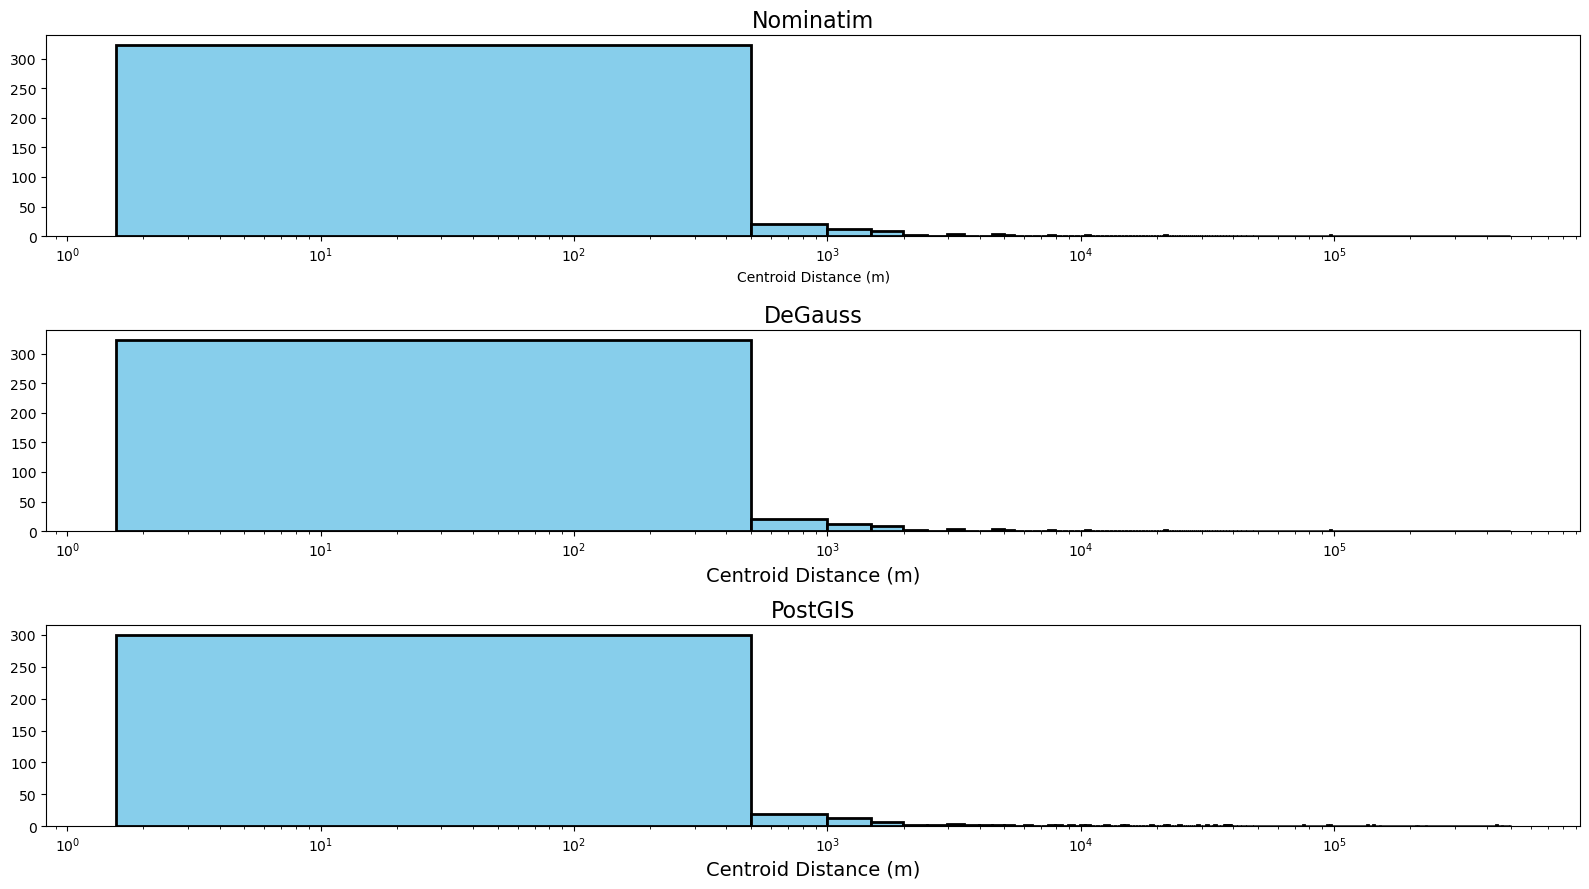

In [78]:
n_bins = 1000
xlim = 100000
edgecolor = "black"
color = "skyblue"
lw=2
title_fontsize=16
label_fontsize=14

fig, axs = plt.subplots(3, 1, figsize=(16,9))
axs[0].hist(nominatim_df_source.centroid_dist, bins=n_bins, color=color, edgecolor=edgecolor, lw=lw)
# axs[0].set_xlim(xlim)
axs[0].set_xscale('log')
axs[0].set_title('Nominatim', fontsize=title_fontsize)
axs[0].set_xlabel('Centroid Distance (m)') 

axs[1].hist(degauss_df_source.centroid_dist, bins=n_bins, color=color, edgecolor=edgecolor, lw=lw)
# axs[1].set_xlim(xlim
axs[1].set_xscale('log')
axs[1].set_title('DeGauss', fontsize=title_fontsize)
axs[1].set_xlabel('Centroid Distance (m)', fontsize=label_fontsize) 

axs[2].hist(postgis_df_source.centroid_dist, bins=n_bins, color=color, edgecolor=edgecolor, lw=lw)
# axs[2].set_xlim(xlim)
axs[2].set_xscale('log')
axs[2].set_title('PostGIS', fontsize=title_fontsize)
axs[2].set_xlabel('Centroid Distance (m)', fontsize=label_fontsize) 

fig.tight_layout()

In [1]:
n_bins = 1000
xlim = 100000
edgecolor = "black"
color = "skyblue"
lw=2
title_fontsize=16
label_fontsize=14

fig, axs = plt.subplots(3, 1, figsize=(16,9))
axs[0].hist(nominatim_df_source.centroid_dist, bins=n_bins, color=color, edgecolor=edgecolor, lw=lw)
# axs[0].set_xlim(xlim)
# axs[0].set_xscale('log')
axs[0].set_title('Nominatim', fontsize=title_fontsize)
axs[0].set_xlabel('Centroid Distance (m)') 

axs[1].hist(degauss_df_source.centroid_dist, bins=n_bins, color=color, edgecolor=edgecolor, lw=lw)
# axs[1].set_xlim(xlim
# axs[1].set_xscale('log')
axs[1].set_title('DeGauss', fontsize=title_fontsize)
axs[1].set_xlabel('Centroid Distance (m)', fontsize=label_fontsize) 

axs[2].hist(postgis_df_source.centroid_dist, bins=n_bins, color=color, edgecolor=edgecolor, lw=lw)
# axs[2].set_xlim(xlim)
# axs[2].set_xscale('log')
axs[2].set_title('PostGIS', fontsize=title_fontsize)
axs[2].set_xlabel('Centroid Distance (m)', fontsize=label_fontsize) 

fig.tight_layout()

NameError: name 'plt' is not defined

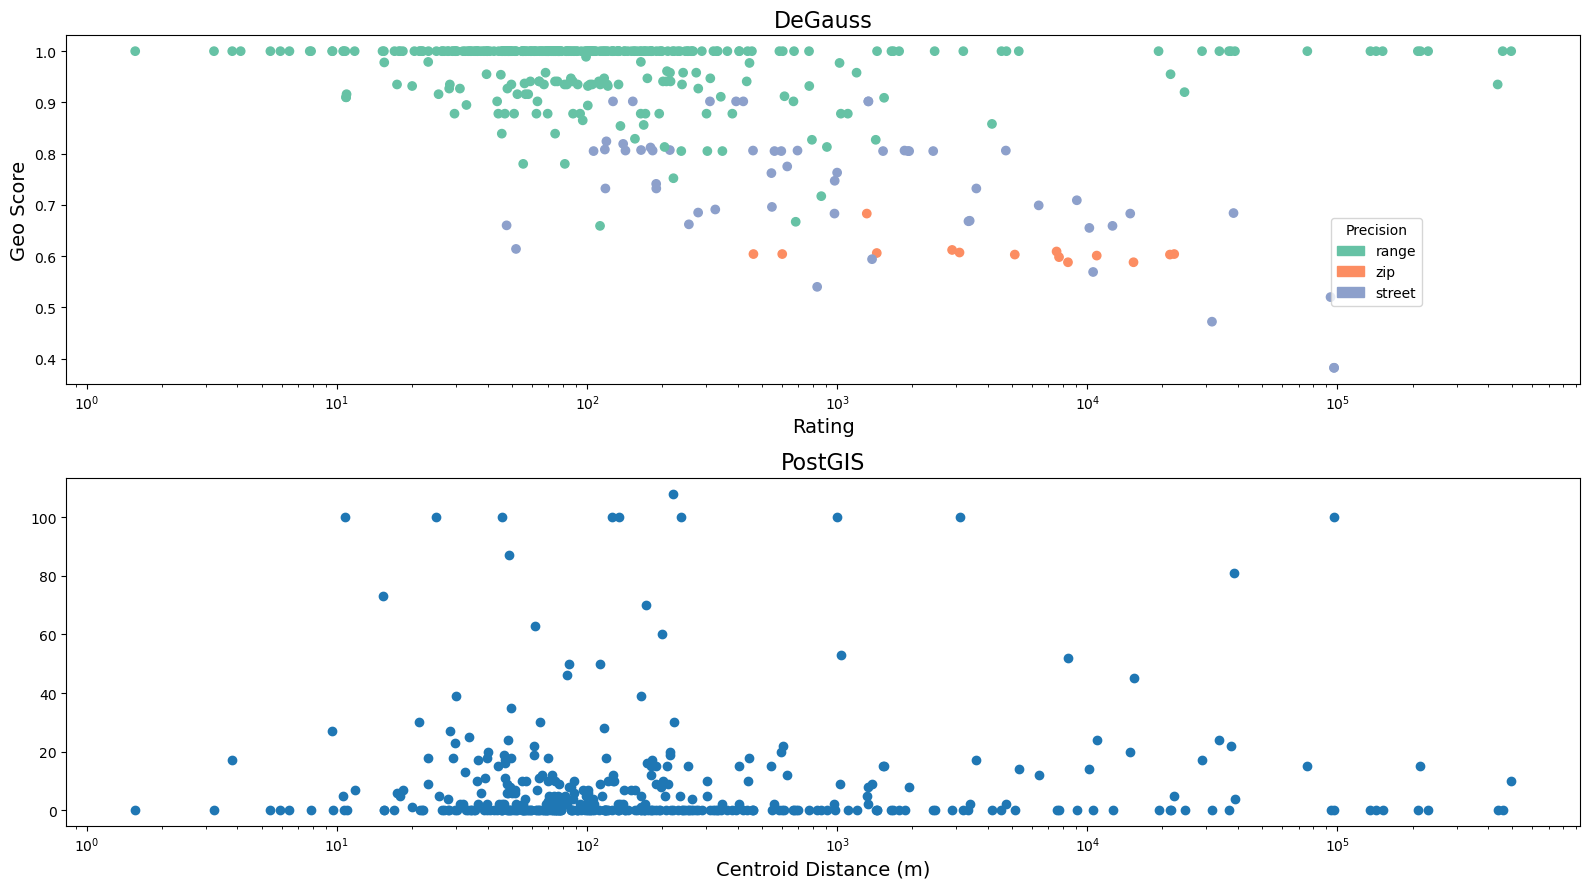

In [79]:
n_bins = 1000
xlim = 100000
color = "black"

fig, axs = plt.subplots(2, 1, figsize=(16,9))
# axs[0].plot(nominatim_df_source.centroid_dist, nominatim_df_source.importance)
# # axs[0].set_xlim(xlim)
# # axs[0].set_xscale('log')
# axs[0].set_title('Nominatim')
# axs[0].set_xlabel('Centroid Distance (m)') 

levels, categories = pd.factorize(degauss_df_source.geo_precision)
colors = [plt.cm.Set2(i) for i in levels]
handles = [matplotlib.patches.Patch(color=plt.cm.Set2(i), label=c) for i, c in enumerate(categories)]

axs[0].scatter(degauss_df_source.centroid_dist, degauss_df_source.geo_score, c=colors)
# axs[1].set_xlim(xlim
axs[0].set_xscale('log')
axs[0].set_title('DeGauss', fontsize=title_fontsize)
axs[0].set_xlabel('Centroid Distance (m)', fontsize=label_fontsize)
axs[0].set_ylabel('Geo Score', fontsize=label_fontsize)
axs[0].legend(handles=handles, title='Precision', loc="center right", bbox_to_anchor=(0.5, 0.1, 0.4, 0.5))

axs[1].scatter(postgis_df_source.centroid_dist, postgis_df_source.rating)
# axs[2].set_xlim(xlim)
axs[1].set_xscale('log')
axs[1].set_title('PostGIS', fontsize=title_fontsize)
axs[1].set_xlabel('Centroid Distance (m)', fontsize=label_fontsize) 
axs[0].set_xlabel('Rating', fontsize=label_fontsize)

fig.tight_layout()